# 2022-02-16 QR Stability

* Sahitya's office hours: Friday 11-12:30

## Last time

* Gram-Schmidt process
* QR factorization

## Today
* Stability and ill conditioning
* Intro to performance modeling
* Classical vs Modified Gram-Schmidt
* Right vs left-looking algorithms

In [1]:
using LinearAlgebra
using Plots
using Polynomials
default(linewidth=4, legendfontsize=12)

function vander(x, k=nothing)
    if isnothing(k)
        k = length(x)
    end
    m = length(x)
    V = ones(m, k)
    for j in 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

vander (generic function with 2 methods)

# Gram-Schmidt orthogonalization

Suppose we're given some vectors and want to find an orthogonal basis for their span.

$$ \Bigg[ a_1 \Bigg| a_2 \Bigg] = \Bigg[ q_1 \Bigg| q_2 \Bigg] \begin{bmatrix} r_{11} & r_{12} \\ 0 & r_{22} \end{bmatrix} $$

# A naive algorithm

In [2]:
function gram_schmidt_naive(A)
    m, n = size(A)
    Q = zeros(m, n)
    R = zeros(n, n)
    for j in 1:n
        v = A[:,j]
        for k in 1:j-1
            r = Q[:,k]' * v
            v -= Q[:,k] * r
            R[k,j] = r
        end
        R[j,j] = norm(v)
        Q[:,j] = v / R[j,j]
    end
    Q, R
end

gram_schmidt_naive (generic function with 1 method)

In [3]:
x = LinRange(-1, 1, 10)
A = vander(x, 4)
Q, R = gram_schmidt_naive(A)
@show norm(Q' * Q - I)
@show norm(Q * R - A);

norm(Q' * Q - I) = 3.684346652564232e-16
norm(Q * R - A) = 1.6779947319649215e-16


# What do orthogonal polynomials look like?

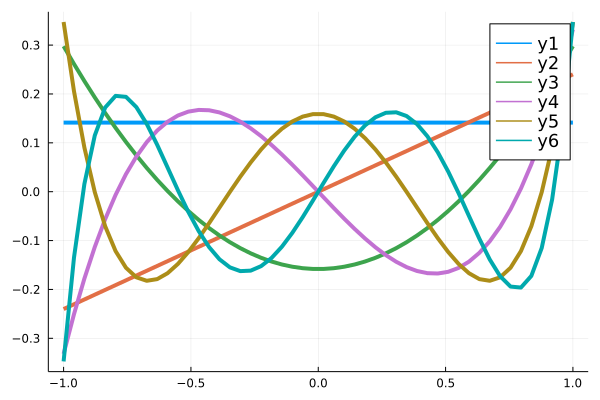

In [5]:
x = LinRange(-1, 1, 50)
A = vander(x, 6)
Q, R = gram_schmidt_naive(A)
plot(x, Q)

What happens if we use more than 50 values of $x$? Is there a continuous limit?

# Solving equations using $QR = A$

If $A x = b$ then $Rx = Q^T b$. (Why is it easy to solve with $R$?)

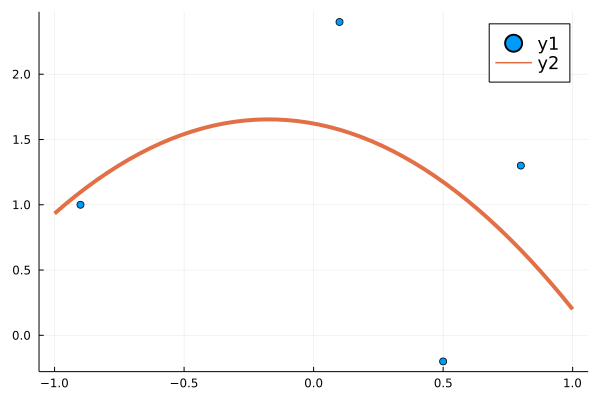

In [6]:
x1 = [-0.9, 0.1, 0.5, 0.8] # points where we know values
y1 = [1, 2.4, -0.2, 1.3]
scatter(x1, y1)
A = vander(x1, 3)
Q, R = gram_schmidt_naive(A)
p = R \ (Q' * y1)
p = A \ y1
plot!(x, vander(x, 3) * p)

# How accurate is it?

In [7]:
m = 10
x = LinRange(-1, 1, m)
A = vander(x, m)
Q, R = gram_schmidt_naive(A)
@show norm(Q' * Q - I)
@show norm(Q * R - A)

norm(Q' * Q - I) = 2.2794113434933815e-13
norm(Q * R - A) = 3.6437542961698333e-16


3.6437542961698333e-16

# A variant with more parallelism

\begin{align}
(I - q_2 q_2^T) (I - q_1 q_1^T) v &= (I - q_1 q_1^T - q_2 q_2^T + q_2 q_2^T q_1 q_1^T) v \\
&= \Bigg( I - \Big[ q_1 \Big| q_2 \Big] \begin{bmatrix} q_1^T \\ q_2^T \end{bmatrix} \Bigg) v
\end{align}

In [8]:
function gram_schmidt_classical(A)
    m, n = size(A)
    Q = zeros(m, n)
    R = zeros(n, n)
    for j in 1:n
        v = A[:,j]
        R[1:j-1,j] = Q[:,1:j-1]' * v
        v -= Q[:,1:j-1] * R[1:j-1,j]
        R[j,j] = norm(v)
        Q[:,j] = v / norm(v)
    end
    Q, R
end

gram_schmidt_classical (generic function with 1 method)

In [9]:
m = 10
x = LinRange(-1, 1, m)
A = vander(x, m)
Q, R = gram_schmidt_classical(A)
@show norm(Q' * Q - I)
@show norm(Q * R - A)

norm(Q' * Q - I) = 6.339875256299394e-11
norm(Q * R - A) = 1.217027619812654e-16


1.217027619812654e-16

# Why does order of operations matter?

\begin{align}
(I - q_2 q_2^T) (I - q_1 q_1^T) v &= (I - q_1 q_1^T - q_2 q_2^T + q_2 q_2^T q_1 q_1^T) v \\
&= \Bigg( I - \Big[ q_1 \Big| q_2 \Big] \begin{bmatrix} q_1^T \\ q_2^T \end{bmatrix} \Bigg) v
\end{align}
is not exact in finite arithmetic.

# We can look at the size of what's left over

We project out the components of our vectors in the directions of each $q_j$.

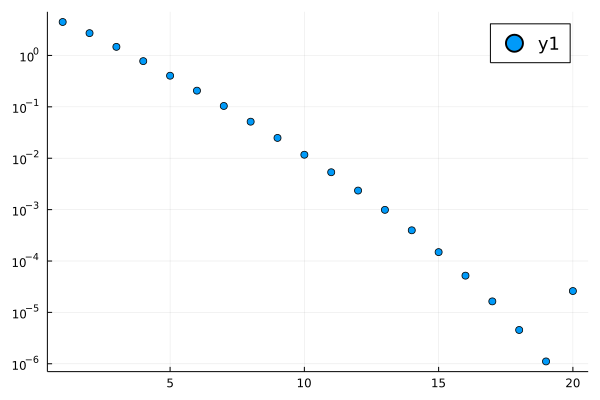

In [14]:
x = LinRange(-1, 1, 20)
A = vander(x)
Q, R = gram_schmidt_classical(A)
scatter(diag(R), yscale=:log10)

# The next vector is almost linearly dependent

norm(v) = 1.4245900685395503


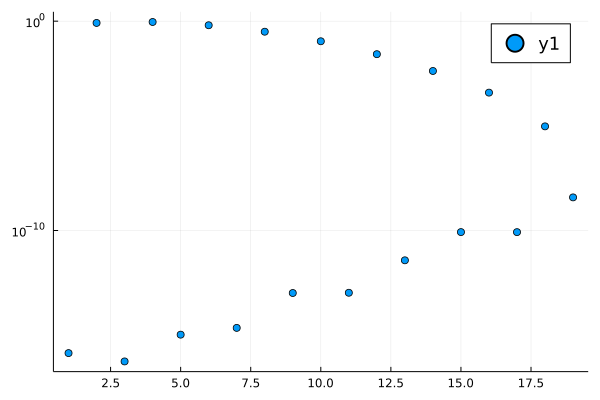

In [18]:
x = LinRange(-1, 1, 20)
A = vander(x)
Q, _ = gram_schmidt_classical(A)
#Q, _ = qr(A)
v = A[:,end]
@show norm(v)
scatter(abs.(Q[:,1:end-1]' * v), yscale=:log10)

# Cost of Gram-Schmidt?

* We'll count flops (addition, multiplication, division*)
* Inner product $\sum_{i=1}^m x_i y_i$?
* Vector "axpy": $y_i = a x_i + y_i$, $i \in [1, 2, \dotsc, m]$.
* Look at the inner loop:
```julia
for k in 1:j-1
    r = Q[:,k]' * v
    v -= Q[:,k] * r
    R[k,j] = r
end
```

<img src="../img/flop-per-byte-dp.png" width="90%" />

# Counting flops is a bad model


* We load a single entry (8 bytes) and do 2 flops (add + multiply). That's an **arithmetic intensity** of 0.25 flops/byte.
* Current hardware can do about 10 flops per byte, so our best algorithms will run at about 2% efficiency.
* Need to focus on memory bandwidth, not flops.

## Dense matrix-matrix mulitply

* [BLIS project](https://github.com/flame/blis/)
* [Analytic modeling](https://www.cs.utexas.edu/users/flame/pubs/TOMS-BLIS-Analytical.pdf)

<img src="../img/blis-microkernel-stack.png" width="70%" />

# Inherent data dependencies

$$ \Bigg[ q_1 \Bigg| q_2 \Bigg| q_3 \Bigg| q_4 \Bigg| q_5 \Bigg] \begin{bmatrix} r_{11} & r_{12} & r_{13} & r_{14} & r_{15} \\
 & r_{22} & r_{23} & r_{24} & r_{25} \\
& & r_{33} & r_{34} & r_{35} \\
&&& r_{44} & r_{45} \\
&&& & r_{55}
\end{bmatrix}
$$

# Right-looking modified Gram-Schmidt

In [19]:
function gram_schmidt_modified(A)
    m, n = size(A)
    Q = copy(A)
    R = zeros(n, n)
    for j in 1:n
        R[j,j] = norm(Q[:,j])
        Q[:,j] /= R[j,j]
        R[j,j+1:end] = Q[:,j]'*Q[:,j+1:end]
        Q[:,j+1:end] -= Q[:,j]*R[j,j+1:end]'
    end
    Q, R
end

gram_schmidt_modified (generic function with 1 method)

In [20]:
m = 20
x = LinRange(-1, 1, m)
A = vander(x, m)
Q, R = gram_schmidt_modified(A)
@show norm(Q' * Q - I)
@show norm(Q * R - A)

norm(Q' * Q - I) = 8.486718528276085e-9
norm(Q * R - A) = 8.709998074379606e-16


8.709998074379606e-16

# Classical versus modified?

* Classical
  * Really unstable, orthogonality error of size $1 \gg \epsilon_{\text{machine}}$
  * Don't need to know all the vectors in advance
* Modified
  * Needs to be right-looking for efficiency
  * Less unstable, but orthogonality error $10^{-9} \gg \epsilon_{\text{machine}}$

In [21]:
m = 10
x = LinRange(-1, 1, m)
A = vander(x, m)
Q, R = qr(A)
@show norm(Q' * Q - I)

norm(Q' * Q - I) = 2.1776697623015113e-15


2.1776697623015113e-15